# **DATA PREPROCESSING BASED ON EDA INSIGHTS**



##  Home Loan Dataset: Preprocessing Overview

This notebook continues from the **Exploratory Data Analysis (EDA)** phase, where data quality checks, missing value imputation, and outlier treatment were completed.
We now focus on preparing the dataset for machine learning by engineering relevant features, transforming skewed variables, encoding categorical features, and scaling numerical ones.
All steps directly align with the evidence-based recommendations from the *Home Loan EDA Report*.

### **Preprocessing Plan (Post-EDA)**

1. **Feature Engineering** - Create Total_income, Loan_to_income, and interaction features.
3. **Encoding categorical and Ordinal columns**
4. **Splitting into target and Features / Feature Selection**
6. **Target Handling** - Class imbalance using SMOTE
7. **Scaling** - RobustScaler
8. **Feature Importance Analysis**

2. **Skewness Handling**

   * Apply **log transformation** to right-skewed variables:

     * `ApplicantIncome`, `CoapplicantIncome`, and `LoanAmount`
   * Recheck skewness visually (histogram/QQ plot) to confirm normalization.

3. **Encoding Categorical Variables**

   * **Label Encoding** for binary features:

     * `Gender`, `Education`, `Self_Employed`, `Married`
   * **One-Hot Encoding** for nominal multi-class features:

     * `Property_Area`
   * **Ordinal Encoding** for ordered categories:

     * `Credit_History` (0 = poor, 1 = good)

4. **Feature Scaling**

   * Standardize continuous variables using `RobustScaler`:

     * `ApplicantIncome`, `CoapplicantIncome`, `LoanAmount`, `Total_Income`, `EMI`


6. **Target Variable Encoding**

   * Encode the binary target:

     * `Loan_Status`: map `Y → 1`, `N → 0`

7. **Train-Test Split**

   * Perform a **stratified 80/20 split** to maintain the same proportion of approved vs. rejected loans.

---

### **Key EDA Evidence Driving These Steps**

| EDA Finding                                  | Preprocessing Action                |
| -------------------------------------------- | ----------------------------------- |
| Income and loan amount highly skewed         | Apply log transformation            |
| `Credit_History` most predictive of approval | Retain as main predictor            |
| `Loan_Amount_Term` offers low variance       | Drop or treat as constant           |
| Property area affects loan status            | One-hot encode                      |
| Married and Total_Income interact            | Create interaction feature          |
| Dependents slightly affect approval odds     | Engineer income-per-dependent ratio |



#### **1. Import Libraries and Load Data**

In [90]:
# core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing libraries
from sklearn.preprocessing import StandardScaler, RobustScaler,LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# Statistical libraries
from scipy import stats
from scipy.stats import zscore, skew

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [91]:
# The URL of the raw train data CSV file
# url = 'https://raw.githubusercontent.com/ek-chris/Practice_datasets/refs/heads/main/home_loan_train.csv'

# Read the CSV file directly into a pandas DataFrame
df = pd.read_csv("cleaned_home_data.csv")
print("Dataset loaded successfully!")
print("\nFirst 5 rows of the DataFrame:")
df.head()

# Create a copy for preprocessing
df_processed = df.copy()

Dataset loaded successfully!

First 5 rows of the DataFrame:


In [92]:
df_processed.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,1
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1


In [93]:
df_processed.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [94]:
# setting load_id as the index
df_processed.set_index("Loan_ID", inplace = True)

#### **2. EDA-Based Data Quality Assessment**

In [95]:
# 1. Check for missing values (EDA showed no missing values)
print("1. Missing Values")
missing_values = df_processed.isnull().sum()

if missing_values.sum() > 0:
    print(missing_values[missing_values > 0])
else:
    print("No missing values found (as expected from EDA)")

# 2. Check for duplicates
print("\n2. Duplicate Rows:")
duplicates = df_processed.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
if duplicates > 0:
    print(f"Percentage of duplicates: {(duplicates / len(df_processed)) * 100:.2f}%")
else:
    print("No duplicated values found (as expected from EDA)")

# 3. Check skewness for variables identified in EDA as right-skewed
print("\n3. Skewness Analysis (EDA identified right-skewed variables):")
skewed_vars = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount"]
for var in skewed_vars:
    if var in df_processed.columns:
        skewness = skew(df_processed[var])
        print(f"{var}: skewness = {skewness:.3f} "
              f"({'right-skewed' if skewness > 0.5 else 'approximately normal'})")
    else:
        print(f"{var}: not found in dataset")

# 4. Check correlation with target (EDA evidence)
print("\n4. Correlation with Target Variable (Loan_Status):")
target_col = "Loan_Status"

if target_col in df_processed.columns:
    correlations = df_processed.corr(numeric_only=True)[target_col].sort_values(
        key=abs, ascending=False
    )

    print("High-signal features (|correlation| > 0.2):")
    high_signal = correlations[abs(correlations) > 0.2].drop(target_col, errors="ignore")
    for feature, corr in high_signal.items():
        print(f"  {feature}: {corr:.3f}")

    print("\nLow-signal features (|correlation| < 0.1):")
    low_signal = correlations[abs(correlations) < 0.1]
    for feature, corr in low_signal.items():
        print(f"  {feature}: {corr:.3f}")

else:
    print(f"Target column '{target_col}' not found in df_processed")

1. Missing Values
No missing values found (as expected from EDA)

2. Duplicate Rows:
Number of duplicate rows: 0
No duplicated values found (as expected from EDA)

3. Skewness Analysis (EDA identified right-skewed variables):
ApplicantIncome: skewness = 6.524 (right-skewed)
CoapplicantIncome: skewness = 7.473 (right-skewed)
LoanAmount: skewness = 2.736 (right-skewed)

4. Correlation with Target Variable (Loan_Status):
High-signal features (|correlation| > 0.2):
  Credit_History: 0.541

Low-signal features (|correlation| < 0.1):
  CoapplicantIncome: -0.059
  LoanAmount: -0.033
  Loan_Amount_Term: -0.023
  Dependents: 0.010
  ApplicantIncome: -0.005


In [96]:
df_processed.columns

Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

## Handle Missing Values

In [97]:
df_processed.isna().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [98]:
# checking numerical columns
numerical = df_processed.select_dtypes(include=["int64", "float64"]).columns
numerical

Index(['Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_Status'],
      dtype='object')

In [99]:
df_processed.isna().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

#### **3. Handle Duplicates**


In [100]:
# Remove duplicates if any (EDA didn't report duplicates, but let's be thorough)
if duplicates > 0:
    print(f"Removing {duplicates} duplicate rows...")
    df_processed = df_processed.drop_duplicates()
    print(f"Dataset shape after removing duplicates: {df_processed.shape}")
else:
    print("No duplicates to remove (as expected from EDA)")


No duplicates to remove (as expected from EDA)


#### **3. Feature Engineering**

Implement the specific feature engineering recommendations from the EDA report

**Total Income**

In [102]:
print("FEATURE ENGINEERING BASED ON EDA RECOMMENDATIONS")
print("Creating new derived variables to improve model interpretability and performance.\n")

# 1. Total_Income: Combine ApplicantIncome and CoapplicantIncome
if all(col in df_processed.columns for col in ["ApplicantIncome", "CoapplicantIncome"]):
    df_processed["Total_Income"] = df_processed["ApplicantIncome"] + df_processed["CoapplicantIncome"]
    print("Created 'Total_Income' (Applicant + Coapplicant)")
else:
    print("Could not create 'Total_Income'; missing one or more income columns")
#2. Loan_to_Income= Total_Income/LoanAmount
print(f"Dataset shape after feature engineering: {df_processed.shape}")
print("Feature engineering complete. Ready for encoding and scaling.\n")


FEATURE ENGINEERING BASED ON EDA RECOMMENDATIONS
Creating new derived variables to improve model interpretability and performance.

Created 'Total_Income' (Applicant + Coapplicant)
Dataset shape after feature engineering: (614, 13)
Feature engineering complete. Ready for encoding and scaling.



In [103]:
df_processed.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income
Loan_ID,,,,,,,,,,,,,
LP001002,Male,No,0,Graduate,No,5849,0.0,128.0,360.0,1.0,Urban,1,5849.0
LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0,6091.0
LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1,3000.0
LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1,4941.0
LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1,6000.0


In [104]:
# coverting loan amount term datatype from float to int
df_processed["Loan_Amount_Term"]=df_processed["Loan_Amount_Term"].astype(int)
df_processed["Loan_Amount_Term"]

Loan_ID
LP001002    360
LP001003    360
LP001005    360
LP001006    360
LP001008    360
           ... 
LP002978    360
LP002979    180
LP002983    360
LP002984    360
LP002990    360
Name: Loan_Amount_Term, Length: 614, dtype: int64

In [105]:
# putting loan amountterm from years to month
df_processed["Loan_Amount_Term_Year"]= round((df_processed["Loan_Amount_Term"]/12),1 ).astype(int)
df_processed["Loan_Amount_Term_Year"].head()

Loan_ID
LP001002    30
LP001003    30
LP001005    30
LP001006    30
LP001008    30
Name: Loan_Amount_Term_Year, dtype: int64

**EMI: LoanAmount/Loan_Amount_Term_Year**

In [106]:
# 3. EMI: LoanAmount/Loan_Amount_Term_Year
if all(col in df_processed.columns for col in ["LoanAmount", "Loan_Amount_Term_Year"]):
    df_processed["EMI"] = df_processed["LoanAmount"] / df_processed["Loan_Amount_Term_Year"]
    print("Created 'EMI': LoanAmount / Loan_Amount_Term_Year)")
else:
    print("Could not create 'Total_Income'; missing one or more income columns")
    
df_processed["EMI"]    

Created 'EMI': LoanAmount / Loan_Amount_Term_Year)


Loan_ID
LP001002    4.266667
LP001003    4.266667
LP001005    2.200000
LP001006    4.000000
LP001008    4.700000
              ...   
LP002978    2.366667
LP002979    2.666667
LP002983    8.433333
LP002984    6.233333
LP002990    4.433333
Name: EMI, Length: 614, dtype: float64

**Has CoApplicant**

In [107]:
df_processed.Married.unique()

array(['No', 'Yes'], dtype=object)

| Numeric | Category   | Meaning               |
| ------- | ---------- | --------------------- |
| 1       | **Yes**    | Married               |
| 0       | **No**     | Not Married           |


In [108]:
# mapping the marital status
df_processed["Marital_status"] = df_processed["Married"].map({"Yes": 1, "No": 0})    

**Dependents**

In [109]:
# checking the datatypes of the dependents columns
df_processed["Dependents"].dtypes

dtype('int64')

In [110]:
df_processed["Dependents"]=df_processed["Dependents"].astype(int)

In [111]:
df_processed.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Total_Income,Loan_Amount_Term_Year,EMI,Marital_status
Loan_ID,,,,,,,,,,,,,,,,
LP001002,Male,No,0,Graduate,No,5849,0.0,128.0,360,1.0,Urban,1,5849.0,30,4.266667,0
LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360,1.0,Rural,0,6091.0,30,4.266667,1
LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360,1.0,Urban,1,3000.0,30,2.200000,1
LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360,1.0,Urban,1,4941.0,30,4.000000,1
LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360,1.0,Urban,1,6000.0,30,4.700000,0


**Income Category Encoding**

| Numeric | Category   | Meaning               |
| ------- | ---------- | --------------------- |
| <= 1500 | **Low**    | Low Income            |
| > 1500  | **Medium** | Medium Income         |
| > 5000  | **High**   | High Income           |


In [112]:
def map_income_category(income):
    if income <= 1500:
        return "Low"
    elif (income > 1500) and (income <= 5000):
        return "Medium"
    elif income > 5000:
        return "High"
    else:
        return "Very High"
    
df_processed["Income_category"] = df_processed["Total_Income"].apply(map_income_category)
df_processed["Income_category"]    

Loan_ID
LP001002      High
LP001003      High
LP001005    Medium
LP001006    Medium
LP001008      High
             ...  
LP002978    Medium
LP002979    Medium
LP002983      High
LP002984      High
LP002990    Medium
Name: Income_category, Length: 614, dtype: object

In [113]:
# making a copy of our data for scaling
# df_scaling = df_processed.copy()

In [114]:
# making a copy of our data for log transformation
# df_processed = df_processed.copy()

#### **4. Log-Transform Skewed Variables (EDA Recommendation)**

Based on EDA findings, transform the right-skewed variables identified

In [115]:
# Log-transform skewed variables as recommended by EDA
print("LOG-TRANSFORMING SKEWED VARIABLES")
print("EDA identified these variables as right-skewed and recommended log transformation:")

skewed_vars = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount","Total_Income", "EMI"]
# Variables to log-transform based on EDA findings
def handled_skewed_var(df):
    for var in skewed_vars:
        if var in df_processed.columns:
            # checking if variable has zero or negative values
            min_val = df_processed[var].min()
            if min_val <= 0:
                # use log1p for variales with zeros
                df_processed[f'{var}_log'] = np.log1p(df_processed[var])
                print(f"{var}: Applied log1p transformation (had{min_val:.3f} minimum value)")
            else:
                # use log for positive values only
                df_processed[f'{var}_log'] = np.log(df_processed[var])
                print(f"{var}: APplied log transformation")
                
                # check skewness befire and after
                original_skew = skew(df_processed[var])
                transformed_skew = skew(df_processed[f'{var}_log'])
                
                print(f"Original Skewness: {original_skew:.3f}, Transformed Skewness: {transformed_skew:.3f}")
    return df
print(f"\nDataset shape after log transformation: {df_processed.shape}")
print("New log-transformes columns: ", [col for col in df_processed.columns if "_log" in col])

LOG-TRANSFORMING SKEWED VARIABLES
EDA identified these variables as right-skewed and recommended log transformation:

Dataset shape after log transformation: (614, 17)
New log-transformes columns:  []


In [116]:
handled_skewed_var(df_processed)

ApplicantIncome: APplied log transformation
Original Skewness: 6.524, Transformed Skewness: 0.478
CoapplicantIncome: Applied log1p transformation (had0.000 minimum value)
LoanAmount: APplied log transformation
Original Skewness: 2.736, Transformed Skewness: -0.195
Total_Income: APplied log transformation
Original Skewness: 5.620, Transformed Skewness: 1.074
EMI: APplied log transformation
Original Skewness: 9.936, Transformed Skewness: 0.701


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,...,Total_Income,Loan_Amount_Term_Year,EMI,Marital_status,Income_category,ApplicantIncome_log,CoapplicantIncome_log,LoanAmount_log,Total_Income_log,EMI_log
Loan_ID,,,,,,,,,,,,,,,,,,,,,
LP001002,Male,No,0,Graduate,No,5849,0.0,128.0,360,1.0,...,5849.0,30,4.266667,0,High,8.674026,0.000000,4.852030,8.674026,1.450833
LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360,1.0,...,6091.0,30,4.266667,1,High,8.430109,7.319202,4.852030,8.714568,1.450833
LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360,1.0,...,3000.0,30,2.200000,1,Medium,8.006368,0.000000,4.189655,8.006368,0.788457
LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360,1.0,...,4941.0,30,4.000000,1,Medium,7.856707,7.765993,4.787492,8.505323,1.386294
LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360,1.0,...,6000.0,30,4.700000,0,High,8.699515,0.000000,4.948760,8.699515,1.547563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360,1.0,...,2900.0,30,2.366667,0,Medium,7.972466,0.000000,4.262680,7.972466,0.861482
LP002979,Male,Yes,3,Graduate,No,4106,0.0,40.0,180,1.0,...,4106.0,15,2.666667,1,Medium,8.320205,0.000000,3.688879,8.320205,0.980829
LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360,1.0,...,8312.0,30,8.433333,1,High,8.996157,5.484797,5.533389,9.025456,2.132192


#### **6. Encoding**

In [117]:
# mapping loan_status from abject to int to check correlation 
# df_processed["Loan_Status"] = df_processed["Loan_Status"].map({"Y":1,"N": 0})

In [118]:
# mapping credit history from int to object to check correlation
# df_processed["Credit_History"] = df_processed["Credit_History"].map({1.0:"good", 0.0:"bad"})

In [119]:
# Encoding the categorical columns
label_encoder = LabelEncoder()
# ordinal_encoder = OrdinalEncoder(categories=[['Low', 'Medium', 'High', 'Very High']])
col_to_encode = ['Gender','Married', 'Education', 'Self_Employed', 'Property_Area',"Credit_History" ]
df_processed['Gender'] = label_encoder.fit_transform(df_processed['Gender'])
df_processed['Married'] = label_encoder.fit_transform(df_processed['Married'])
df_processed['Education'] = label_encoder.fit_transform(df_processed['Education'])
df_processed['Self_Employed'] = label_encoder.fit_transform(df_processed['Self_Employed'])
df_processed['Property_Area'] = label_encoder.fit_transform(df_processed['Property_Area'])
df_processed['Credit_History'] =label_encoder.fit_transform(df_processed[['Credit_History']])
df_processed['Loan_Status'] =label_encoder.fit_transform(df_processed[['Loan_Status']])

c:\Users\SHOPINVERSE\Desktop\ai_fellowship_module_3\my_venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\SHOPINVERSE\Desktop\ai_fellowship_module_3\my_venv\Lib\site-packages\sklearn\preprocessing\_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [120]:
# label_encoder =LabelEncoder()
# encode_columns = ["Gender","Education","Self_Employed","Property_Area","Married"]
# for col in encode_columns:
#     label_encoder.fit_transform(df_processed[col])
     

In [121]:
ordinal_encoder =OrdinalEncoder(categories=[["Low","Medium","High","Very High"]])
df_processed["Income_category"]=ordinal_encoder.fit_transform(df_processed[["Income_category"]])  

In [122]:
df_processed.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,...,Total_Income,Loan_Amount_Term_Year,EMI,Marital_status,Income_category,ApplicantIncome_log,CoapplicantIncome_log,LoanAmount_log,Total_Income_log,EMI_log
Loan_ID,,,,,,,,,,,,,,,,,,,,,
LP001002,1,0,0,0,0,5849,0.0,128.0,360,1,...,5849.0,30,4.266667,0,2.0,8.674026,0.000000,4.852030,8.674026,1.450833
LP001003,1,1,1,0,0,4583,1508.0,128.0,360,1,...,6091.0,30,4.266667,1,2.0,8.430109,7.319202,4.852030,8.714568,1.450833
LP001005,1,1,0,0,1,3000,0.0,66.0,360,1,...,3000.0,30,2.200000,1,1.0,8.006368,0.000000,4.189655,8.006368,0.788457
LP001006,1,1,0,1,0,2583,2358.0,120.0,360,1,...,4941.0,30,4.000000,1,1.0,7.856707,7.765993,4.787492,8.505323,1.386294
LP001008,1,0,0,0,0,6000,0.0,141.0,360,1,...,6000.0,30,4.700000,0,2.0,8.699515,0.000000,4.948760,8.699515,1.547563


### **5. Data Splitting**

In [123]:
# seperating features and target
X = df_processed.drop("Loan_Status", axis=1)#featured
y=df_processed["Loan_Status"]#target

### **6. Feature Selection**

Droppinng the original column befor log transformation and retaining the feature engineered column

In [124]:
df_processed.columns


Index(['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed',
       'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status',
       'Total_Income', 'Loan_Amount_Term_Year', 'EMI', 'Marital_status',
       'Income_category', 'ApplicantIncome_log', 'CoapplicantIncome_log',
       'LoanAmount_log', 'Total_Income_log', 'EMI_log'],
      dtype='object')

In [125]:
col_to_drop=["ApplicantIncome", "CoapplicantIncome", "LoanAmount","Loan_Amount_Term","Total_Income","EMI"]
X= X.drop(col_to_drop, axis=1)

In [126]:
# displaying output
X

,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Loan_Amount_Term_Year,Marital_status,Income_category,ApplicantIncome_log,CoapplicantIncome_log,LoanAmount_log,Total_Income_log,EMI_log
Loan_ID,,,,,,,,,,,,,,,
LP001002,1,0,0,0,0,1,2,30,0,2.0,8.674026,0.000000,4.852030,8.674026,1.450833
LP001003,1,1,1,0,0,1,0,30,1,2.0,8.430109,7.319202,4.852030,8.714568,1.450833
LP001005,1,1,0,0,1,1,2,30,1,1.0,8.006368,0.000000,4.189655,8.006368,0.788457
LP001006,1,1,0,1,0,1,2,30,1,1.0,7.856707,7.765993,4.787492,8.505323,1.386294
LP001008,1,0,0,0,0,1,2,30,0,2.0,8.699515,0.000000,4.948760,8.699515,1.547563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LP002978,0,0,0,0,0,1,0,30,0,1.0,7.972466,0.000000,4.262680,7.972466,0.861482
LP002979,1,1,3,0,0,1,0,15,1,1.0,8.320205,0.000000,3.688879,8.320205,0.980829
LP002983,1,1,1,0,0,1,2,30,1,2.0,8.996157,5.484797,5.533389,9.025456,2.132192


### **7. Target Class Imbalance Handling(SMOTE)**

In [127]:
smote = SMOTE(sampling_strategy="minority")
X,y=smote.fit_resample(X,y)
y.value_counts()

Loan_Status
1    422
0    422
Name: count, dtype: int64

In [128]:
# splitting the data to train and test

# first split: 80% train+val, 20% test
X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

print(f"Data Split Results")
print(f"Training Set:{X_train.shape}({(X_train.shape[0]/len(X))*100:.1f}%)")
print(f"Test Set:{X_test.shape}({(X_test.shape[0]/len(X))*100:.1f}%)")

Data Split Results
Training Set:(675, 15)(80.0%)
Test Set:(169, 15)(20.0%)


In [129]:
# creating copies of X and y split before scaling
X_copy=X.copy()
y_copy = y.copy()

### **8. Feature Scaling using Robust Scaler**

Apply Robust Scaler as recommended by EDA


In [130]:
print("Feature Scaling(Robust Scale)")
print("EDA recommended")
scaler = RobustScaler()

# applying scaler to the train and test data
scaled_X = scaler.fit_transform(X_train)
scaled_X_te = scaler.fit_transform(X_test)
scaled_X_train = pd.DataFrame(scaled_X, columns=X_train.columns)
scaled_X_test = pd.DataFrame(scaled_X_te, columns=X_test.columns)
print("Succesfuly Scaled")
# transform validation

print(scaled_X_train.median().round(4))
print(scaled_X_test.median().round(4))


Feature Scaling(Robust Scale)
EDA recommended
Succesfuly Scaled
Gender                   0.0
Married                  0.0
Dependents               0.0
Education                0.0
Self_Employed            0.0
Credit_History           0.0
Property_Area            0.0
Loan_Amount_Term_Year    0.0
Marital_status           0.0
Income_category          0.0
ApplicantIncome_log      0.0
CoapplicantIncome_log    0.0
LoanAmount_log           0.0
Total_Income_log         0.0
EMI_log                  0.0
dtype: float64
Gender                   0.0
Married                  0.0
Dependents               0.0
Education                0.0
Self_Employed            0.0
Credit_History           0.0
Property_Area            0.0
Loan_Amount_Term_Year    0.0
Marital_status           0.0
Income_category          0.0
ApplicantIncome_log      0.0
CoapplicantIncome_log    0.0
LoanAmount_log           0.0
Total_Income_log         0.0
EMI_log                  0.0
dtype: float64


### **9. Feature Importance Analysis**

FEATURE IMPORTANCE ANALYSIS
Top 10 features by correlation with Loan_Status:
 1. Loan_Amount_Term_Year: 0.114
 2. EMI_log: 0.071
 3. Property_Area: 0.066
 4. Education: 0.048
 5. Self_Employed: 0.034
 6. Dependents: 0.028
 7. Income_category: 0.025
 8. Total_Income_log: 0.023
 9. LoanAmount_log: 0.013
10. Gender: 0.013
Engineered features in top 10: ['Loan_Amount_Term_Year', 'LoanAmount_log', 'Total_Income_log', 'EMI_log']


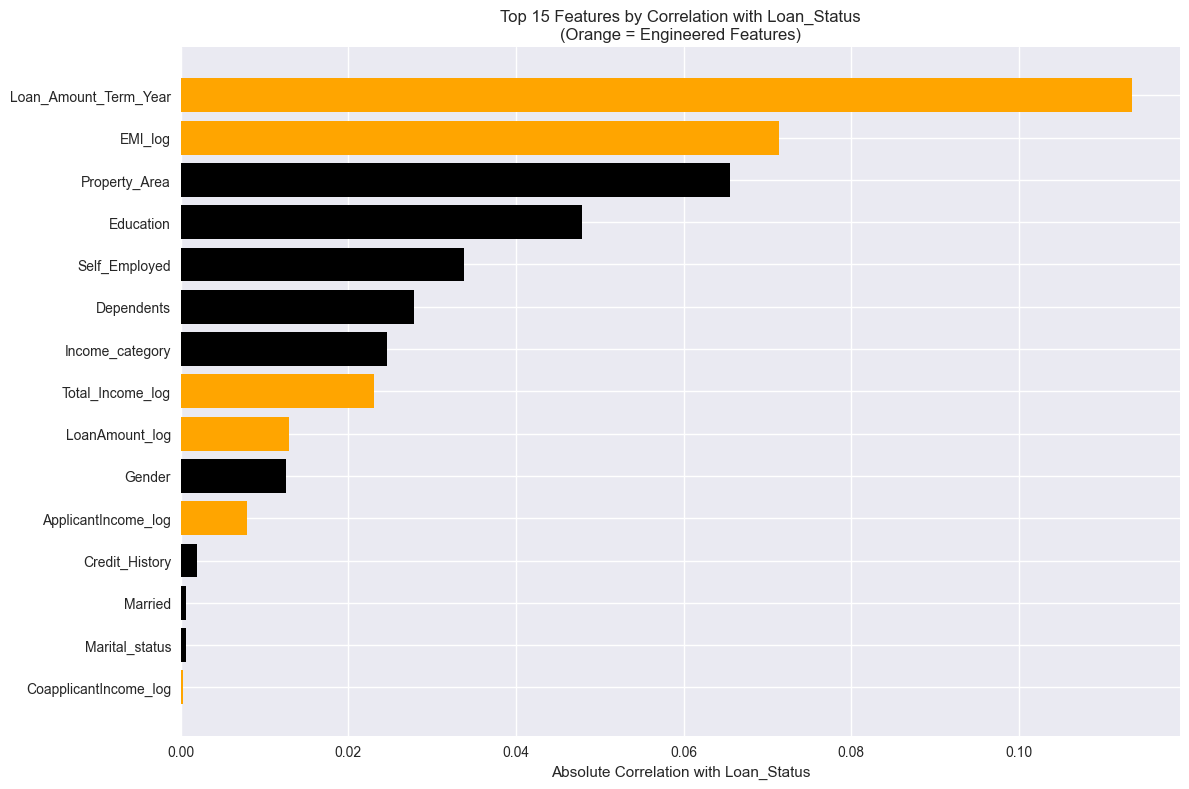


✓ Feature importance analysis completed
✓ 4 engineered features in top 10


In [131]:
# Feature importance analysis to validate EDA-based engineering
print("FEATURE IMPORTANCE ANALYSIS")

# calculate correlation with target for all features
feature_correlations = scaled_X_train.corrwith(y_train).abs().sort_values(ascending=False)

print("Top 10 features by correlation with Loan_Status:")
for i, (feature, corr) in enumerate(feature_correlations.head(10).items(),1):
    print(f"{i:2d}. {feature}: {corr:.3f}")
    
#checking  if engineered features are among to features
engineered_features =[col for col in scaled_X_train.columns if any(keyword in col.lower() for keyword in["log","total","year"])]
print(f"Engineered features in top 10: {[f for f in engineered_features if f in feature_correlations.head(10).index]}")

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = feature_correlations.head(15)
colors = ['orange'if any(keyword in f.lower() for keyword in ["log","total","year"]) else 'black' for f in top_features.index]

plt.barh(range(len(top_features)), top_features.values, color=colors)
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('Absolute Correlation with Loan_Status')
plt.title('Top 15 Features by Correlation with Loan_Status\n(Orange = Engineered Features)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\n✓ Feature importance analysis completed")
print(f"✓ {len([f for f in engineered_features if f in feature_correlations.head(10).index])} engineered features in top 10")



In [ ]:
# feature_correlations

#### **10. Save Preprocessed Data**

In [133]:
print("SAVING PREPROCESSED DATA ")

# saving scaled data to csv
scaled_X_train.to_csv("scaled_X_train.csv", index=True)
scaled_X_test.to_csv("scaled_X_test.csv", index=True)

# Save target variables
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

# save preproessing objects using joblib
import joblib
joblib.dump(scaler, "robust_scaler.pkl")
joblib.dump(X.columns.tolist(), "selected_features.pkl")

# save feature importance
feature_importance_df = pd.DataFrame({
    'feature': feature_correlations.index,
    'correlation': feature_correlations.values
})
feature_importance_df.to_csv('feature_importance.csv', index=False)

# Save preprocessing summary
preprocessing_summary = {
    'original_shape': df.shape,
    'final_shape': df_processed.shape,
    'selected_features': X.columns.tolist(),
    'engineered_features': engineered_features,
    'train_samples': scaled_X_train.shape[0],
    'test_samples': scaled_X_test.shape[0],
    'scaling_method': 'RobustScaler',
    'outlier_treatment': 'Log Transformation',
    'log_transformed': ["ApplicantIncome", "CoapplicantIncome", "LoanAmount","Total_Income", "EMI"]
}

import json
with open('preprocessing_summary.json', 'w') as f:
    json.dump(preprocessing_summary, f, indent=2)

print("- Preprocessed data saved successfully!")
print("\nFiles created:")
print("- scaled_X_train.csv, X_val_scaled.csv, scaled_X_test.csv")
print("- y_train.csv, y_test.csv")
print("- scaler.pkl, selected_features.pkl")
print("- feature_importance.csv, preprocessing_summary.json")



SAVING PREPROCESSED DATA 
- Preprocessed data saved successfully!

Files created:
- scaled_X_train.csv, X_val_scaled.csv, scaled_X_test.csv
- y_train.csv, y_test.csv
- scaler.pkl, selected_features.pkl
- feature_importance.csv, preprocessing_summary.json


In [134]:
# Final preprocessing summary
print(".....PREPROCESSING SUMMARY BASED ON EDA INSIGHTS.....")
print(f"Original dataset shape: {df.shape}")
print(f"Final processed dataset shape: {df_processed.shape}")
print(f"Selected features: {len(X)}")
print(f"Training samples: {scaled_X_train.shape[0]}")
print(f"Test samples: {scaled_X_test.shape[0]}")
print("\n.....PREPROCESSING STEPS COMPLETED (EDA-BASED).....")
print("> Data quality assessment (no missing values, no duplicated values)")
print("> Log-transformation of skewed variables ('ApplicantIncome','CoapplicantIncome','LoanAmount', 'Total_income', 'EMI')")
print("> Feature engineering based on EDA recommendations:")
print(" - Total_Income = ApplicantIncome + Coapplicantincome")
print("  - Loan_Amount_Term_Year = Loan_Amount_Term / 12")
print("  - EMI = Loan_amount / Loan_Amount_Term_year")
print("  - Has_Coapplicant = Yes or No")
print("  - Income_category = Low, Medium, High and Very High")
print("> Feature selection ('ApplicantIncome','CoapplicantIncome','LoanAmount', 'Total_income', 'EMI', 'Loan_Amount_Term')")
print("> SMOTE (Handles class imbalance)")
print("> RobustScaler applied (EDA recommendation)")
print("> Feature importance analysis (validates engineered features)")
print("> Data export (ready for modeling)")
print("\n.....EDA EVIDENCE IMPLEMENTED.....")
print("> Skewed variables log-transformed as recommended")
print("> Features have been engineered")
print(f"\n Preprocessing completed successfully!!!!!!")
print(".....Ready for modeling phase with EDA-informed preprocessing")

.....PREPROCESSING SUMMARY BASED ON EDA INSIGHTS.....
Original dataset shape: (614, 13)
Final processed dataset shape: (614, 22)
Selected features: 844
Training samples: 675
Test samples: 169

.....PREPROCESSING STEPS COMPLETED (EDA-BASED).....
> Data quality assessment (no missing values, no duplicated values)
> Log-transformation of skewed variables ('ApplicantIncome','CoapplicantIncome','LoanAmount', 'Total_income', 'EMI')
> Feature engineering based on EDA recommendations:
 - Total_Income = ApplicantIncome + Coapplicantincome
  - Loan_Amount_Term_Year = Loan_Amount_Term / 12
  - EMI = Loan_amount / Loan_Amount_Term_year
  - Has_Coapplicant = Yes or No
  - Income_category = Low, Medium, High and Very High
> Feature selection ('ApplicantIncome','CoapplicantIncome','LoanAmount', 'Total_income', 'EMI', 'Loan_Amount_Term')
> SMOTE (Handles class imbalance)
> RobustScaler applied (EDA recommendation)
> Feature importance analysis (validates engineered features)
> Data export (ready for m